# **Brain Tumor Segmentation Project:**

## **Overview**
Welcome to the Brain Tumor Segmentation Project! This Jupyter Notebook is designed for both newcomers and experienced professionals in the field of machine learning. Our aim is to develop a model capable of accurately segmenting brain tumors from MRI scans using deep learning techniques.

## **Dataset**
We are utilizing the Brain Tumor Segmentation (BraTS2020) dataset from Kaggle (https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation/data). This dataset includes multimodal MRI scans in NIfTI format (.nii.gz), encompassing various volumes, including:
- Native (T1)
- Post-contrast T1-weighted (T1Gd)
- T2-weighted (T2)
- T2 Fluid Attenuated Inversion Recovery (T2-FLAIR)

The tumor annotations are categorized into:
- Necrotic and non-enhancing tumor core (NCR/NET — label 1)
- Peritumoral edema (ED — label 2)
- GD-enhancing tumor (ET — label 4)

## **Objective**
Our primary objective is to segment brain tumors by labeling each pixel as "1" for tumor classes (NCR/NET, ED, ET) and "0" otherwise. We plan to employ a 3D U-Net model for automatic segmentation.

## **Approach**
1. **Data Preparation**: Load, preprocess, and normalize the data, followed by train-test splitting.
2. **Model Building**: Design and configure the 3D U-Net model architecture suitable for our segmentation task.
3. **Model Training and Validation**: Train the 3D U-Net model on the prepared dataset and validate its performance.
4. **Model Evaluation**: Assess model performance using metrics like accuracy, precision, recall, and F1 score.
5. **Results and Visualization**: Compare model predictions with ground truth to visualize performance.

## **Target Audience**
This notebook is structured to be accessible for beginners, providing detailed explanations and a step-by-step approach, while also encompassing advanced techniques for seasoned practitioners.

---

*Let's dive into the world of medical imaging and deep learning to make significant strides in healthcare technology!*

# **Step 1: Data Preparation**

## 1.1 Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing necessary libraries
import os
import time
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
import gc
import seaborn as sns
from scipy import stats
from skimage.transform import resize
from skimage.util import montage
import albumentations as A

In [3]:
# Define paths for dataset
ROOT_DIR = '/content/drive/My Drive/BRAIN_TUMOR_SEGMENTATION/INPUT_DATASET/DATASET/brats20-dataset-training-validation'
TRAIN_DIR = os.path.join(ROOT_DIR, 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData')
TEST_DIR = os.path.join(ROOT_DIR, 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData')

In [4]:
# Function to seed everything for reproducibility
def seed_everything(seed=55):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

# Setting the seed
seed_everything()

# Function to load a single MRI scan
def load_mri_scan(path):
    scan = nib.load(path)
    scan = scan.get_fdata()
    return scan

# Example: Load a sample file
sample_filename_1 = os.path.join(TRAIN_DIR, 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
sample_filename_2 = os.path.join(TRAIN_DIR, 'BraTS20_Training_001/BraTS20_Training_001_t1.nii')
sample_filename_3 = os.path.join(TRAIN_DIR, 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii')
sample_filename_4 = os.path.join(TRAIN_DIR, 'BraTS20_Training_001/BraTS20_Training_001_t2.nii')
sample_filename_mask = os.path.join(TRAIN_DIR, 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

In [5]:
sample_img = load_mri_scan(sample_filename_1)

# Display the shape of the sample image
print("Sample Image Shape:", sample_img.shape)

Sample Image Shape: (240, 240, 155)


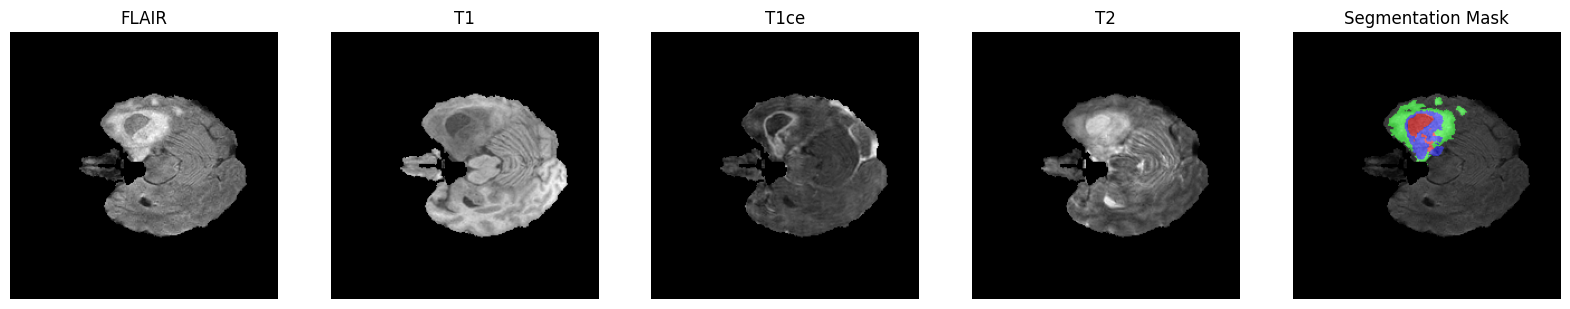

In [6]:
# Function to plot MRI scans and label
def plot_mri_scans(slice_no):
    fig, axes = plt.subplots(1, 5, figsize=(20, 10))
    file_names = [sample_filename_1, sample_filename_2, sample_filename_3, sample_filename_4, sample_filename_mask]
    titles = ['FLAIR', 'T1', 'T1ce', 'T2', 'Segmentation Mask']

    for i, file in enumerate(file_names):
        scan = load_mri_scan(file)[:, :, slice_no]
        if i != 4:  # For MRI scans
            axes[i].imshow(scan, cmap='gray')
        else:  # For the segmentation mask
            # First, display the MRI scan in the background
            background_scan = load_mri_scan(file_names[0])[:, :, slice_no]  # Assuming FLAIR scan as background
            axes[i].imshow(background_scan, cmap='gray')
            # Now overlay the colored label
            label_image = np.zeros((*scan.shape, 3), dtype=np.float32)
            label_image[np.where(scan == 1)] = [1, 0, 0]  # Red for label 1
            label_image[np.where(scan == 2)] = [0, 1, 0]  # Green for label 2
            label_image[np.where(scan == 4)] = [0, 0, 1]  # Blue for label 4
            axes[i].imshow(label_image, alpha=0.5)  # Colored labels over MRI scan

        axes[i].axis('off')
        axes[i].set_title(titles[i])

    plt.show()

# Plot the scans for a specific slice
plot_mri_scans(slice_no=50)

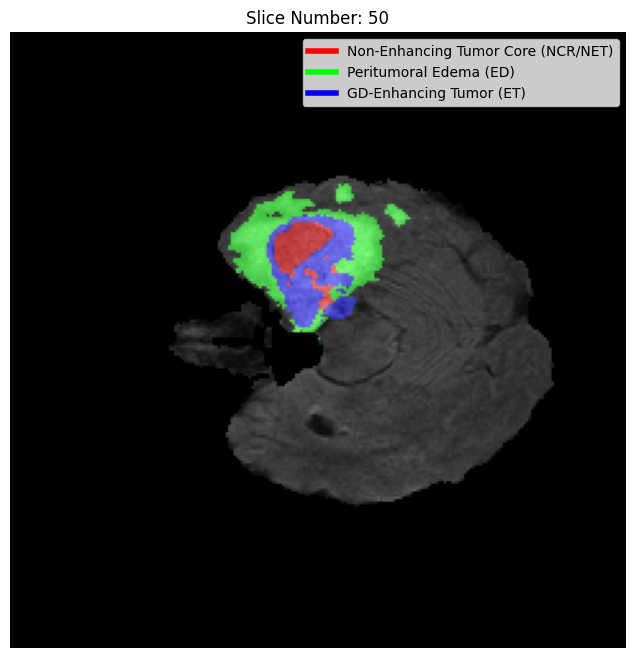

In [7]:
# Function to plot MRI scans and label and their Legend
def plot_label_with_legend(scan_path, label_path, slice_no):
    # Load MRI scan and label
    scan = nib.load(scan_path).get_fdata()
    label = nib.load(label_path).get_fdata()

    plt.figure(figsize=(8, 8))

    # Display MRI scan
    plt.imshow(scan[:, :, slice_no], cmap='gray')

    # Overlay colored labels
    label_image = np.zeros((*label[:, :, slice_no].shape, 3), dtype=np.float32)
    label_image[np.where(label[:, :, slice_no] == 1)] = [1, 0, 0]  # Red for Label 1
    label_image[np.where(label[:, :, slice_no] == 2)] = [0, 1, 0]  # Green for Label 2
    label_image[np.where(label[:, :, slice_no] == 4)] = [0, 0, 1]  # Blue for Label 4
    plt.imshow(label_image, alpha=0.5)

    # Create a legend for the labels
    labels = ["Non-Enhancing Tumor Core (NCR/NET)", "Peritumoral Edema (ED)", "GD-Enhancing Tumor (ET)"]
    colors = [plt.Line2D([0], [0], color=c, lw=4) for c in [(1, 0, 0), (0, 1, 0), (0, 0, 1)]]
    plt.legend(colors, labels, loc='upper right')

    plt.title(f'Slice Number: {slice_no}')
    plt.axis('off')
    plt.show()

# Example: Plot a specific slice with colored labels and legend
plot_label_with_legend(sample_filename_1, sample_filename_mask, slice_no=50)

In [8]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 28.2 MB/s eta 0:00:00


In [9]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

# Load the image using SimpleITK
sample_filename = '/content/drive/My Drive/BRAIN_TUMOR_SEGMENTATION/INPUT_DATASET/DATASET/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
sitk_image = sitk.ReadImage(sample_filename)

# Convert SimpleITK image to a NumPy array
image_array = sitk.GetArrayFromImage(sitk_image)

# Define a function to plot each slice
def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    plt.imshow(image_array[layer], cmap='gray')
    plt.title(f'Slice number: {layer}')
    plt.axis('off')
    plt.show()

# Create an interactive plot
interact(explore_3dimage, layer=(0, image_array.shape[0] - 1))

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

<function __main__.explore_3dimage(layer)>

## 1.2 Data Pre-Processing

In [10]:
# Data Preprocessing
# Reading and merging survival info and patient IDs
survival_info_df = pd.read_csv(os.path.join(TRAIN_DIR, 'survival_info.csv'))
name_mapping_df = pd.read_csv(os.path.join(TRAIN_DIR, 'name_mapping.csv'))
name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True)
merged_df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")

In [11]:
# Adding file paths to the dataframe
paths = []
for _, row in merged_df.iterrows():
    id_ = row['Brats20ID']
    path = os.path.join(TRAIN_DIR if 'Training' in id_ else TEST_DIR, id_)
    paths.append(path)
merged_df['path'] = paths

## 1.3 Data Organization

In [12]:
 # Check for NaN values in Age_rank
merged_df["Age_rank"] = merged_df["Age"] // 10 * 10
print("NaN values in Age_rank before:", merged_df["Age_rank"].isna().sum())

# Handling NaN values - Option 1: Filling with a default value (e.g., -1)
# merged_df["Age_rank"].fillna(-1, inplace=True)

# Handling NaN values - Option 2: Dropping rows with NaN values and resetting the index
merged_df.dropna(subset=["Age_rank"], inplace=True)
merged_df.reset_index(drop=True, inplace=True)

print("NaN values in Age_rank after:", merged_df["Age_rank"].isna().sum())

# Stratified K-Fold Split
skf = StratifiedKFold(n_splits=7, random_state=55, shuffle=True)
for fold, (_, val_index) in enumerate(skf.split(merged_df, merged_df["Age_rank"])):
    merged_df.loc[val_index, "fold"] = fold

NaN values in Age_rank before: 133
NaN values in Age_rank after: 0


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


In [13]:
# Selecting data for training and validation
train_df = merged_df[merged_df['fold'] != 0].reset_index(drop=True)
val_df = merged_df[merged_df['fold'] == 0].reset_index(drop=True)

In [14]:
# Displaying the shapes of the dataframes
print("Train DataFrame Shape:", train_df.shape)
print("Validation DataFrame Shape:", val_df.shape)

Train DataFrame Shape: (202, 12)
Validation DataFrame Shape: (34, 12)


In [15]:
# Data Augmentation using Albumentations
def get_augmentations(phase):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                A.HorizontalFlip(),
                # Further augmentation options can be added here
            ]
        )
    list_trfms = A.Compose(list_transforms)
    return list_trfms

## 1.4 Conversion to PyTorch Tensors

In [16]:
# Function to convert Ground Truth Labels to One-Hot Encoding
def one_hot_encode_label(label):
    # Assuming the label has shape (240, 240, 155) and values in {0, 1, 2, 4}
    one_hot_label = np.zeros((3, *label.shape), dtype=np.float32)

    # One-hot encoding
    # Channel 0 - Necrotic and non-enhancing tumor (NCR/NET - label 1)
    # Channel 1 - Peritumoral edema (ED - label 2)
    # Channel 2 - GD-enhancing tumor (ET - label 4)
    one_hot_label[0, :, :, :] = label == 1
    one_hot_label[1, :, :, :] = label == 2
    one_hot_label[2, :, :, :] = label == 4

    return one_hot_label

In [17]:
# Dataset Class for Loading MRI Scans
class BratsDataset(Dataset):
    def __init__(self, df, phase, augmentations=None):
        self.df = df
        self.phase = phase
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['path']
        scan_types = ['flair', 't1', 't1ce', 't2']
        images = []

        for scan_type in scan_types:
            # img_path = f'{path}/BraTS20_Training_{row.Brats20ID}_{scan_type}.nii'
            img_path = f'{path}/BraTS20_Training_{row.Brats20ID.split("_")[2]}_{scan_type}.nii'
            img = load_mri_scan(img_path)

            # Normalize the image
            if img.max() > 0:
                img = img / img.max()

            img = img.astype(np.float32)
            images.append(img)

        # Stack images to create a multi-channel volume
        images = np.stack(images, axis=-1)
        print("Image Shape: ", images.shape)

        # Change image shape from (240, 240, 155, 4) to (4, 240, 240, 155)
        images = np.moveaxis(images, -1, 0)
        print("Image Shape Updated: ", images.shape)

        # Load the mask
        # mask_path = f'{path}/BraTS20_Training_{row.Brats20ID}_seg.nii'
        mask_path = f'{path}/BraTS20_Training_{row.Brats20ID.split("_")[2]}_seg.nii'
        mask = load_mri_scan(mask_path)
        print("Mask Shape: ", mask.shape)

        # One-hot encode the label
        mask = one_hot_encode_label(mask)
        print("Mask Shap after One-Hot Encoding: ", mask.shape)

        # Apply augmentations if any
        if self.augmentations:
            augmented = self.augmentations(image=images, mask=mask)
            images = augmented['image']
            mask = augmented['mask']

        # Convert images and mask to torch tensors
        # images = torch.from_numpy(images).permute(3, 0, 1, 2)  # Convert to CxDxHxW format
        images = torch.from_numpy(images).permute(0, 1, 2, 3)  # Convert to CxDxHxW format
        mask = torch.from_numpy(mask).permute(0, 1, 2, 3)  # Convert to CxDxHxW format
        print("Final Image Shape: ", images.shape)
        print("Final Mask Shape: ", mask.shape)

        return images, mask
        # # Convert images and mask to torch tensors
        # images = torch.from_numpy(images).permute(3, 0, 1, 2)  # Convert to CxDxHxW format
        # # mask = torch.from_numpy(mask).unsqueeze(0)  # Add channel dimension
        # mask = torch.from_numpy(mask)  # Add channel dimension

        # return images, mask

# **Step 2: Model Building**

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Defining a basic block of U-Net model
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

In [19]:
class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=3):
        super(UNet3D, self).__init__()
        # Downscale
        self.down1 = UNetBlock(in_channels, 64)
        self.down2 = UNetBlock(64, 128)
        self.down3 = UNetBlock(128, 256)
        self.down4 = UNetBlock(256, 512)

        # Upscale
        self.up1 = UNetBlock(512 + 256, 256)
        self.up2 = UNetBlock(256 + 128, 128)
        self.up3 = UNetBlock(128 + 64, 64)

        # Final layer
        self.final = nn.Conv3d(64, out_channels, kernel_size=1)

        # Adjusting the output size
        self.upsample = nn.Upsample(size=(240, 240, 155), mode='trilinear', align_corners=True)

    def crop_tensor(self, target_tensor, tensor_to_crop):
        target_size = target_tensor.size()[2:]
        crop_size = tensor_to_crop.size()[2:]
        delta = [cs - ts for ts, cs in zip(target_size, crop_size)]
        delta = [(d // 2, d - d // 2) for d in delta]
        return tensor_to_crop[:,:,delta[0][0]:crop_size[0]-delta[0][1], delta[1][0]:crop_size[1]-delta[1][1], delta[2][0]:crop_size[2]-delta[2][1]]

    def forward(self, x):
        # Downscale
        x1 = self.down1(x)
        x2 = self.down2(F.max_pool3d(x1, 2))
        x3 = self.down3(F.max_pool3d(x2, 2))
        x4 = self.down4(F.max_pool3d(x3, 2))

        # Upscale and Concatenate
        x = F.interpolate(x4, scale_factor=2)
        x3 = self.crop_tensor(x, x3)
        x = torch.cat([x, x3], dim=1)
        x = self.up1(x)

        x = F.interpolate(x, scale_factor=2)
        x2 = self.crop_tensor(x, x2)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x)

        x = F.interpolate(x, scale_factor=2)
        x1 = self.crop_tensor(x, x1)
        x = torch.cat([x, x1], dim=1)
        x = self.up3(x)

        # Final layer with adjusted upsampling
        x = self.final(x)
        x = self.upsample(x)  # Resize to the desired output shape
        return x

In [20]:
# Create the U-Net model
model = UNet3D()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

# Model summary (optional, can be commented out if not needed)
print(model)

UNet3D(
  (down1): UNetBlock(
    (block): Sequential(
      (0): Conv3d(4, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU(inplace=True)
      (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down2): UNetBlock(
    (block): Sequential(
      (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU(inplace=True)
      (2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down3): UNetBlock(
    (block): Sequential(
      (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU(inplace=True)
      (2): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down4): UNetBlock(
    (block): Sequential(
      (0): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), pad

# **Step 3: Model Training and Validation**

In [21]:
save_path = "/content/drive/My Drive/BRAIN_TUMOR_SEGMENTATION/TRAINED_MODEL/"

In [22]:
import copy

# # Initialize lists for storing metrics
# train_accs, val_accs = [], []

# Training and validation loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            data_loader = train_loader if phase == 'train' else val_loader
            # for inputs, labels in data_loader:
            for i, (inputs, labels) in enumerate(data_loader):
                print(f'Processing {phase} data: {i + 1}/{len(data_loader.dataset)}')
                inputs = inputs.to(device)
                # labels = labels.to(device)
                # labels = labels.to(device).long()  # Convert labels to long data type
                labels = labels.to(device).float()  # Convert labels to float data type

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    # Print the output shape
                    print("Output shape:", outputs.shape)

                    # Reshape the labels to remove the channel dimension
                    # labels = labels.squeeze(1)  # This is the line to add

                    loss = criterion(outputs, labels)

                    # # Calculate accuracy
                    # _, preds = torch.max(outputs, 1)
                    # running_corrects += torch.sum(preds == labels.data)
                    # total_samples += inputs.size(0)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            # epoch_acc = running_corrects.double() / total_samples

            print(f'{phase} Loss: {epoch_loss:.4f}')
            # print(f'{phase} Accuracy: {epoch_acc:.4f}')

            # # Store epoch-level accuracy for plotting later
            # if phase == 'train':
            #   train_accs.append(epoch_acc.item())
            # else:
            #   val_accs.append(epoch_acc.item())

            # Save the model if it's the best so far in terms of validation loss
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model
                # torch.save(model.state_dict(), os.path.join(save_path, 'best_model.pth'))

                # Save the model with the epoch number
                model_save_name = f'epoch_{epoch}_val_loss_{best_loss:.4f}.pth'
                torch.save(model.state_dict(), os.path.join(save_path, model_save_name))

    print('Best val loss: {:4f}'.format(best_loss))

    # Load best model weights
    # model.load_state_dict(best_model_wts)
    # return model

In [23]:
# Define DataLoaders for training and validation
# train_loader = DataLoader(BratsDataset(train_df, 'train', get_augmentations('train')), batch_size=1, shuffle=True)
# val_loader = DataLoader(BratsDataset(val_df, 'val', get_augmentations('val')), batch_size=1, shuffle=False)

# Define DataLoaders for training and validation
train_loader = DataLoader(BratsDataset(train_df, 'train', None), batch_size=1, shuffle=True)
val_loader = DataLoader(BratsDataset(val_df, 'val', None), batch_size=1, shuffle=False)

In [24]:
# Define device for training (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Move the model to the specified device
model = model.to(device)

In [25]:
# Train the model
model_ft = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs = 25)

Streaming output truncated to the last 5000 lines.
Final Image Shape:  torch.Size([4, 240, 240, 155])
Final Mask Shape:  torch.Size([3, 240, 240, 155])
Processing train data: 92/202
Output shape: torch.Size([1, 3, 240, 240, 155])
Image Shape:  (240, 240, 155, 4)
Image Shape Updated:  (4, 240, 240, 155)
Mask Shape:  (240, 240, 155)
Mask Shap after One-Hot Encoding:  (3, 240, 240, 155)
Final Image Shape:  torch.Size([4, 240, 240, 155])
Final Mask Shape:  torch.Size([3, 240, 240, 155])
Processing train data: 93/202
Output shape: torch.Size([1, 3, 240, 240, 155])
Image Shape:  (240, 240, 155, 4)
Image Shape Updated:  (4, 240, 240, 155)
Mask Shape:  (240, 240, 155)
Mask Shap after One-Hot Encoding:  (3, 240, 240, 155)
Final Image Shape:  torch.Size([4, 240, 240, 155])
Final Mask Shape:  torch.Size([3, 240, 240, 155])
Processing train data: 94/202
Output shape: torch.Size([1, 3, 240, 240, 155])
Image Shape:  (240, 240, 155, 4)
Image Shape Updated:  (4, 240, 240, 155)
Mask Shape:  (240, 240, 

KeyboardInterrupt: ignored

# **Step 4: Model Evaluation**

## 4.1 Calculate Performance Metrics (accuracy, precision, recall, F1-score)

## 4.2 Analyze Confusion Matrix and Classification Report

## 4.3 Compare Model Performance against Benchmarks

# **Step 5: Results and Visualization**

## 5.1 Summarize Training and Validation Results

## 5.2 Visualize Performance Metrics (charts, graphs)

## 5.3 Interpret Model's findings and discuss insights